# 1. Libraries & Sample Data
The first step is to load our Python Libraries and download the sample data. The dataset represents Apple stock price (1d bars) for the year 2010

In [2]:
# Load Python Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from IPython.display import display, HTML
# for dataframe display
pd.set_option("display.max_rows", None)
def display_df(df):
    # Puts the scrollbar next to the DataFrame
    display(HTML("<div style='height: 200px; overflow: auto; width: fit-content'>" + df.to_html() + "</div>"))

In [5]:
# Download Sample Data
data = pd.read_csv('../l2_04-05/AAPL_2009-2010_6m_all_features_1d.csv')
display_df(data)

,Date,Open,High,Low,Close,Adj Close,Volume,MA5,MA20,STD20,BB_upper,BB_lower,Log_Ret,Vol20
0,2009-04-30,4.507857,4.535714,4.461429,4.493929,3.799404,4.984896e+08,4.453572,4.312857,0.128631,4.570118,4.055596,0.005499,0.287544
1,2009-05-01,4.492857,4.569643,4.492857,4.544286,3.841980,3.975160e+08,4.477429,4.338804,0.119607,4.578017,4.099590,0.011143,0.267026
2,2009-05-04,4.580000,4.723214,4.560000,4.716786,3.987818,6.093584e+08,4.529857,4.367518,0.137583,4.642685,4.092351,0.037257,0.278159
3,2009-05-05,4.580000,4.723214,4.560000,4.716786,3.987818,6.093584e+08,4.588214,4.391839,0.154067,4.699974,4.083704,0.000000,0.273591
4,2009-05-06,4.761786,4.767857,4.650714,4.732143,4.000803,4.735388e+08,4.640786,4.416929,0.166724,4.750376,4.083481,0.003251,0.272976
5,2009-05-07,4.726071,4.728214,4.567857,4.609286,3.896935,5.317760e+08,4.663857,4.439679,0.159903,4.759484,4.119873,-0.026305,0.283717
6,2009-05-08,4.608571,4.686786,4.509286,4.613929,3.900859,4.679640e+08,4.677786,4.456857,0.159209,4.775274,4.138440,0.001007,0.271348
7,2009-05-11,4.548929,4.677143,4.540000,4.627500,3.912333,4.046588e+08,4.659929,4.473554,0.158692,4.790938,4.156169,0.002937,0.271302
8,2009-05-12,4.627143,4.632500,4.401786,4.443571,3.756830,6.094816e+08,4.605286,4.484464,0.147862,4.780187,4.188741,-0.040558,0.306691
9,2009-05-13,4.400357,4.429286,4.263571,4.267500,3.607970,5.959716e+08,4.512357,4.487768,0.141820,4.771407,4.204128,-0.040430,0.341807


# 5. State Space Representation
Now we have a set of data with OHLC data plus some techinchal indicators. Using this data, construct the state space matrix, whese features of the state space are Close Price, 5-day Moving Average, 20-day Moving Average, Bollinger Bands (upper and lower), and 20-day Historical Volatility of Close Price.

In [4]:
# Construct the State Space Matrix
dataset = data.reset_index()[['Date', 'Close', 'MA5', 'MA20', 'BB_upper', 'BB_lower', 'Vol20']]
display_df(dataset)

,Date,Close,MA5,MA20,BB_upper,BB_lower,Vol20
0,2009-04-30,4.493929,4.453572,4.312857,4.570118,4.055596,0.287544
1,2009-05-01,4.544286,4.477429,4.338804,4.578017,4.099590,0.267026
2,2009-05-04,4.716786,4.529857,4.367518,4.642685,4.092351,0.278159
3,2009-05-05,4.716786,4.588214,4.391839,4.699974,4.083704,0.273591
4,2009-05-06,4.732143,4.640786,4.416929,4.750376,4.083481,0.272976
5,2009-05-07,4.609286,4.663857,4.439679,4.759484,4.119873,0.283717
6,2009-05-08,4.613929,4.677786,4.456857,4.775274,4.138440,0.271348
7,2009-05-11,4.627500,4.659929,4.473554,4.790938,4.156169,0.271302
8,2009-05-12,4.443571,4.605286,4.484464,4.780187,4.188741,0.306691
9,2009-05-13,4.267500,4.512357,4.487768,4.771407,4.204128,0.341807


# 6. Z-Score Normalization
Now that we have cleaned our data, and created our features of interest, we must normalize our data. For this example, we use the sklearn StandardScaler, which centers the data and normalizes to unit variance (i.e. performs z-score normalization for us). Do this in a simple, non-rolling fashion.

,Date,Close,MA5,MA20,BB_upper,BB_lower,Vol20
0,2009-04-30,4.493929,4.453572,4.312857,4.570118,4.055596,0.287544
1,2009-05-01,4.544286,4.477429,4.338804,4.578017,4.099590,0.267026
2,2009-05-04,4.716786,4.529857,4.367518,4.642685,4.092351,0.278159
3,2009-05-05,4.716786,4.588214,4.391839,4.699974,4.083704,0.273591
4,2009-05-06,4.732143,4.640786,4.416929,4.750376,4.083481,0.272976
5,2009-05-07,4.609286,4.663857,4.439679,4.759484,4.119873,0.283717
6,2009-05-08,4.613929,4.677786,4.456857,4.775274,4.138440,0.271348
7,2009-05-11,4.627500,4.659929,4.473554,4.790938,4.156169,0.271302
8,2009-05-12,4.443571,4.605286,4.484464,4.780187,4.188741,0.306691
9,2009-05-13,4.267500,4.512357,4.487768,4.771407,4.204128,0.341807


<Axes: >

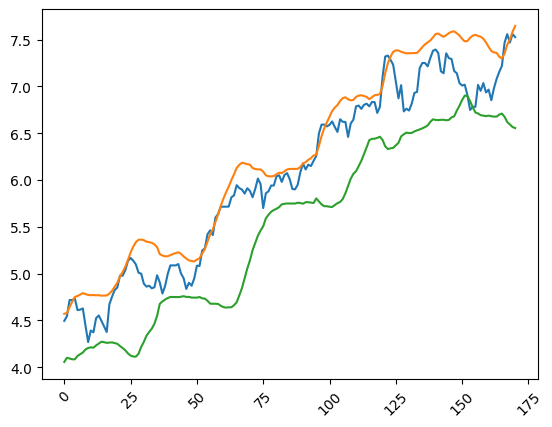

In [6]:
# Display & Plot Un-normalized Dataset
display_df(dataset)
dataset['Close'].plot()
dataset['BB_upper'].plot()
dataset['BB_lower'].plot(rot=45)

In [7]:
# Normalize Dataset with StandardScaler
normlist = []
static_normed_dataset = pd.DataFrame(index=dataset.index)
for col in dataset.columns:
    if col == 'Date':
        static_normed_dataset[col] = dataset[col]
        continue
    normalizer = StandardScaler()
    column_data = pd.DataFrame(dataset[col])
    normalizer.fit(column_data)
    static_normed_dataset[col] = normalizer.transform(column_data).flatten()
    normlist.append(normalizer)

<Axes: >

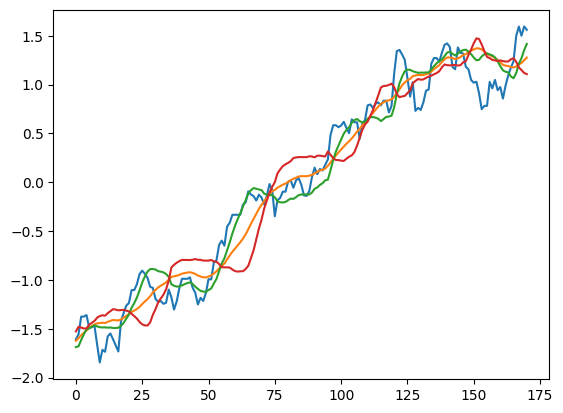

In [8]:
# Plot Normalized Features: Close, MA20, BB Upper, BB Lower
static_normed_dataset['Close'].plot()
static_normed_dataset['MA20'].plot()
static_normed_dataset['BB_upper'].plot()
static_normed_dataset['BB_lower'].plot()

<Axes: >

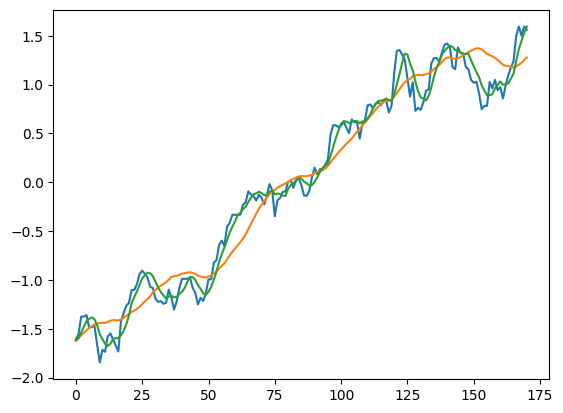

In [9]:
# Plot Normalized Features: Close, MA20, MA5
static_normed_dataset['Close'].plot()
static_normed_dataset['MA20'].plot()
static_normed_dataset['MA5'].plot()

<Axes: >

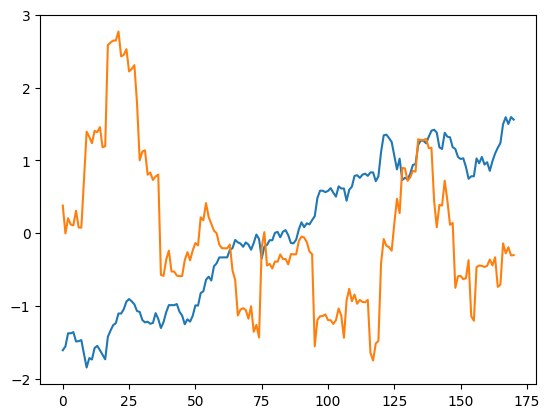

In [9]:
# Plot Normalized Features: Close, Volatility
static_normed_dataset['Close'].plot()
static_normed_dataset['Vol20'].plot()

# 7. Rolling Z-Score Normalization
Now that we have cleaned our data, and created our features of interest, we must normalize our data. For this example, we use the sklearn StandardScaler, which centers the data and normalizes to unit variance. Due to the fact that our data is time-series data, it is best practice to do this in a rolling fashion. We choose 20 days as our window for normalization, and run the StandardScaler in a rolling (non-overlapping) fashion. 

In [10]:
# Display raw dataset (unnormalized) 
display_df(dataset)

,Date,Close,MA5,MA20,BB_upper,BB_lower,Vol20
0,2009-04-30,4.493929,4.453572,4.312857,4.570118,4.055596,0.287544
1,2009-05-01,4.544286,4.477429,4.338804,4.578017,4.099590,0.267026
2,2009-05-04,4.716786,4.529857,4.367518,4.642685,4.092351,0.278159
3,2009-05-05,4.716786,4.588214,4.391839,4.699974,4.083704,0.273591
4,2009-05-06,4.732143,4.640786,4.416929,4.750376,4.083481,0.272976
5,2009-05-07,4.609286,4.663857,4.439679,4.759484,4.119873,0.283717
6,2009-05-08,4.613929,4.677786,4.456857,4.775274,4.138440,0.271348
7,2009-05-11,4.627500,4.659929,4.473554,4.790938,4.156169,0.271302
8,2009-05-12,4.443571,4.605286,4.484464,4.780187,4.188741,0.306691
9,2009-05-13,4.267500,4.512357,4.487768,4.771407,4.204128,0.341807


In [10]:
# Normalize the chosen price data & features
# 注意这里是分段归一化，每个step内归一化，实际并不会使用这种方法
normed_dataset = pd.DataFrame(index=dataset.index, columns=dataset.columns)
step = 20
for col in dataset.columns:
    n = 0
    if col == 'Date':
        normed_dataset[col] = dataset[col]
        continue
    while n<=len(data.index):
        normalizer = StandardScaler()
        if n == 0:
            column_data = dataset.loc[:n+step, col]
            normalizer.fit(column_data.values.reshape(-1, 1))
            normed_dataset.loc[:n+step, col] = normalizer.transform(column_data.values.reshape(-1, 1)).flatten()
        elif n+step >= len(data.index):
            column_data = dataset.loc[n:, col]
            normalizer.fit(column_data.values.reshape(-1, 1))
            normed_dataset.loc[n:,col] = normalizer.transform(column_data.values.reshape(-1, 1)).flatten()
        else:
            column_data = dataset.loc[n:n+step, col]
            normalizer.fit(column_data.values.reshape(-1, 1))
            normed_dataset.loc[n:n+step, col] = normalizer.transform(column_data.values.reshape(-1, 1)).flatten()
        n += step
        # normlist.append(normalizer)
display_df(normed_dataset)


,Date,Close,MA5,MA20,BB_upper,BB_lower,Vol20
0,2009-04-30,-0.498277,-0.923737,-2.311213,-2.424338,-1.836809,-0.796838
1,2009-05-01,-0.175715,-0.662103,-1.933253,-2.320603,-1.227992,-1.222017
2,2009-05-04,0.929236,-0.087135,-1.514973,-1.471287,-1.328172,-0.991319
3,2009-05-05,0.929236,0.55285,-1.160685,-0.718872,-1.44783,-1.08597
4,2009-05-06,1.027606,1.129385,-0.795211,-0.056918,-1.450921,-1.098713
5,2009-05-07,0.240643,1.382402,-0.463813,0.0627,-0.947306,-0.876132
6,2009-05-08,0.270384,1.535152,-0.213574,0.270082,-0.690368,-1.132469
7,2009-05-11,0.357315,1.339318,0.029642,0.475802,-0.445023,-1.133406
8,2009-05-12,-0.820845,0.740066,0.188578,0.334609,0.005726,-0.400042
9,2009-05-13,-1.94867,-0.279054,0.2367,0.219295,0.218662,0.327652


<Axes: >

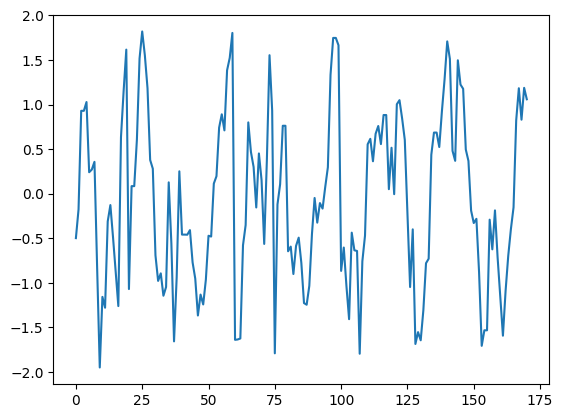

In [19]:
# Plot Normalized Features: Close, MA20, BB Upper, BB Lower
normed_dataset['Close'].plot()
# normed_dataset['MA20'].plot()
# normed_dataset['BB_upper'].plot()
# normed_dataset['BB_lower'].plot()

<Axes: >

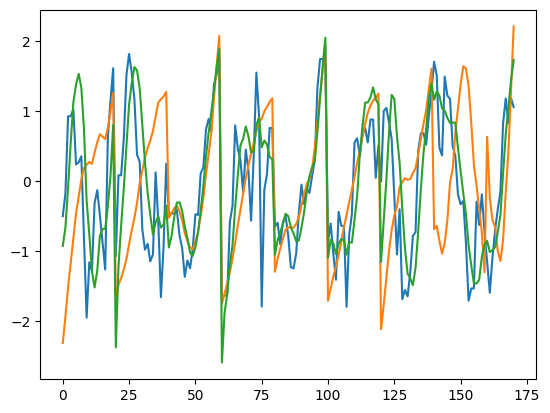

In [12]:
# Plot Normalized Features: Close, MA20, MA5
normed_dataset['Close'].plot()
normed_dataset['MA20'].plot()
normed_dataset['MA5'].plot()

<Axes: >

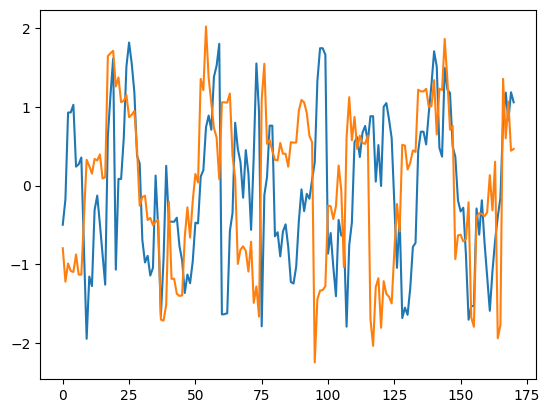

In [13]:
# Plot Normalized Features: Close, Volatility
normed_dataset['Close'].plot()
normed_dataset['Vol20'].plot()

In [ ]:
normed_dataset.to_csv('AAPL_2009-2010_6m_normed_1d.csv')

In [11]:
def rolling_standardization(dataset, window_size=20):
    """滚动窗口标准化（更适合时间序列）"""
    normed_dataset = dataset.copy()
    
    for col in dataset.columns:
        if col != 'Date':
            # 使用滚动窗口计算均值和标准差，包含当前step
            rolling_mean = dataset[col].rolling(window=window_size, min_periods=1).mean()
            rolling_std = dataset[col].rolling(window=window_size, min_periods=1).std()
            
            # 避免除零
            rolling_std = rolling_std.replace(0, 1)
            
            normed_dataset[col] = (dataset[col] - rolling_mean) / rolling_std
    
    return normed_dataset

data2 = pd.read_csv('../l2_04-05/AAPL_2009-2010_6m_all_features_1d.csv')
dataset2 = data.reset_index()[['Date', 'Close', 'MA5', 'MA20', 'BB_upper', 'BB_lower', 'Vol20']]

print(dataset2.head())
roll_normed_data = rolling_standardization(dataset2)
roll_normed_data = roll_normed_data.dropna()
display(roll_normed_data.head())


         Date     Close       MA5      MA20  BB_upper  BB_lower     Vol20
0  2009-04-30  4.493929  4.453572  4.312857  4.570118  4.055596  0.287544
1  2009-05-01  4.544286  4.477429  4.338804  4.578017  4.099590  0.267026
2  2009-05-04  4.716786  4.529857  4.367518  4.642685  4.092351  0.278159
3  2009-05-05  4.716786  4.588214  4.391839  4.699974  4.083704  0.273591
4  2009-05-06  4.732143  4.640786  4.416929  4.750376  4.083481  0.272976


,Date,Close,MA5,MA20,BB_upper,BB_lower,Vol20
19,2009-05-28,1.768523,0.918575,1.347215,1.543215,0.958882,1.853532
20,2009-05-29,1.684500,1.624176,1.556259,2.049737,0.785858,1.618423
21,2009-06-01,2.042561,2.316900,1.816915,2.759469,0.369779,1.557791
22,2009-06-02,1.806276,2.290613,1.903042,2.773280,-0.041261,1.088451
23,2009-06-03,1.828157,2.212050,1.988807,2.669285,-0.591283,1.009004


<Axes: >

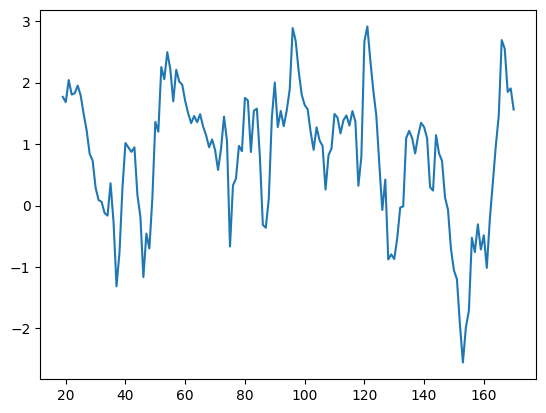

In [12]:
# Plot Normalized Features: Close, MA20, BB Upper, BB Lower
roll_normed_data['Close'].plot()
# roll_normed_data['MA20'].plot()
# roll_normed_data['BB_upper'].plot()
# roll_normed_data['BB_lower'].plot()